## Create case number diagram:
Go through weekly WHO situation reports and patient database numbers, keep the higher number

In [2]:
import re
import os

path_to_dropbox='/Users/evogytis/Dropbox/Ebolavirus_Phylogeography/'
cases_path=path_to_dropbox+'Case counts by district/'

report_root='2016-Feb-22_'
filenames=[report_root+'GIN.csv',report_root+'SLE.csv',report_root+'LBR.csv']
rename={report_root+'GIN.csv':'GIN',report_root+'SLE.csv':'SLE',report_root+'LBR.csv':'LBR'}

map_to_standard={'yomou':'Yamou'}
map_to_actual={}
standard_path=path_to_dropbox+'Maps/standardDistricts.tsv'
for line in open(standard_path,'r'):
    l=line.strip('\n').split('\t')
    ## map parts of a district name to its standard name
    # split by space, keep last word in lower case
    # e.g River Gee = gee, Grand Cape Mount = mount.
    map_to_standard[l[3].lower()]=l[-1]
    
    actual=l[1]
    if 'actual' not in actual:
        actual=actual.decode('utf8')
        map_to_actual[l[-1]]=actual

local_output='/Users/evogytis/Documents/EBOV_output/'
output=local_output+'EBOV_maxCases.csv'
try:
    os.remove(output)
    print 'Removed previous file'
except:
    pass

out=open(output,'w')
dates=[]

## iterate over country reports
for fname in filenames:
    print fname
    data={}
    for line in open(cases_path+fname,'r'):
        l=line.replace('"','').strip('\n').split(',')
        
        ## header
        if 'Location' in l[0]:
            ## find all epi weeks
            cerberus=re.findall('([0-9]+) ([A-Za-z]+) to [0-9]+ [A-Za-z]+ ([0-9]+)|([0-9]+) to [0-9]+ ([A-Za-z]+) ([0-9]+)|([0-9]+) ([A-Za-z]+) ([0-9]+) to [0-9]+ [A-Za-z]+ [0-9]+',','.join(l))
            
            ## if dates is empty - populate it with epi weeks
            if len(dates)==0:
                dates=['-'.join((y[0],y[1][:3],y[2])) for y in [[z for z in x[::-1] if z!=''] for x in cerberus]]
                print>>out,'country,district,standard,%s'%(','.join(dates))
                
        ## starting actual data
        elif l[0]!='':
            district=l[0]

            if data.has_key(district)==False:
                ## each district has a situation report and patient database lists
                data[district]={'situation':[0.0 for e in dates],'patient':[0.0 for e in dates]}
            
            ## combine confirmed and suspected cases for patient database
            if 'Patient database' in l[1] and 'Confirmed' in l[3]:
                data[district]['patient']=[int(x) if (x not in [' ','']) else 0 for x in l[4:]]
            elif 'Patient database' in l[1] and 'Probable' in l[3]:
                data[district]['patient']=[int(x)+y if (x not in [' ','']) else 0 for x,y in zip(l[4:],data[district]['patient'])]
                
            ## likewise for situation report
            elif 'Situation report' in l[1] and 'Confirmed' in l[3]:
                data[district]['situation']=[int(x) if (x not in [' ','']) else 0 for x in l[4:]]
            elif 'Situation report' in l[1] and 'Probable' in l[3]:
                data[district]['situation']=[int(x)+y if (x not in [' ','']) else 0 for x,y in zip(l[4:],data[district]['situation'])]
    
    ## for every district report maximum (either situation report or patient database) combined (confirmed+suspected) cases
    for q in sorted(data.keys()): 
        counts=[max(a,b) for a,b in zip(data[q]['patient'],data[q]['situation'])]
        ## output to file, including standardised district names
        print>>out,'%s,%s,%s,%s'%(rename[fname],q,map_to_standard[q.lower().replace(' ','').replace("'",'').replace('area','')],','.join(map(str,counts)))
            
## add Mandiana - didn't report any suspected cases
print>>out,'%s,%s,%s,%s'%('GIN','MANDIANA','Mandiana',','.join(['' for x in dates]))

out.close()

Removed previous file
2016-Feb-22_GIN.csv
2016-Feb-22_SLE.csv
2016-Feb-22_LBR.csv


In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use("pgf")

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.patches as patches
#from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as path_effects
from IPython.display import HTML

from ebov_data import *

## set default matplotlib font and font size
# typeface='Arial'
typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42
# mpl.rcParams['ps.fonttype'] = 42


#mpl.rcParams['text.usetex'] = True
# ##############################################
# ## Define paths
# ##############################################

if locations:
    pass
else:
    status()
    setFocusCountries(['SLE','LBR','GIN'])
    setColourMaps()
    loadData()

## path to a file with sequence names
xml_path=path_to_dropbox+'Sequences/Aug2016_1610_genomes/Joint/HomogenousGLM/All_1610/Run1/Makona_1610_cds_ig.joint_GLM.xml'

##############################################
## Import sequence names
##############################################
sequences=[]
for line in open(xml_path,'r'):
    l=line.strip('\n')
    cerberus=re.search('<taxon id="(EBOV\|[A-Za-z0-9\|\-\_\.\?]+)">',l)
    
    if cerberus is not None:
        sequences.append(cerberus.group(1).split('|'))

isolation_dates=[decimalDate(x) for x in column(sequences,-1)]
extremes=['|'.join(x) for x in sorted(sequences,key=lambda z:decimalDate(z[-1])) if decimalDate(x[-1])==max(isolation_dates) or decimalDate(x[-1])==min(isolation_dates)]

print '\noldest sequence:\t%s\nyoungest sequence:\t%s'%(extremes[0],extremes[1])
##############################################
## Import sequences
##############################################

##############################################
## Define timeline
##############################################
timeline=['2013-%02d-01'%x for x in range(12,13)]
timeline+=['2014-%02d-01'%x for x in range(1,13)]
timeline+=['2015-%02d-01'%x for x in range(1,13)]
timeline+=['2016-%02d-01'%x for x in range(1,3)]
##############################################
## Define timeline
##############################################

path='<iframe style="border: 0; width: 400px; height: 405px;" src="https://bandcamp.com/EmbeddedPlayer/album=1879093915/size=large/bgcol=333333/linkcol=ffffff/artwork=small/track=748478573/transparent=true/" seamless><a href="http://obsrr.bandcamp.com/album/patogi-gelm">PATOGI GELME by OBSRR</a></iframe>'

# maxByCountry={x.split('_')[0]:max([sum(cases_byDistrict[x].values())]) for x in cases_byDistrict.keys()}
# maxByCountry={y:([totalCaseCounts[z] for z in totalCaseCounts.keys() if y in z]) for y in unique([x.split('_')[0] for x in countries])}
# maxByCountry={y:([totalCaseCounts[z] for z in totalCaseCounts.keys() if y in z]) for y in unique([x.split('_')[0] for x in countries])}
seq_byCountry={y:[x for x in sequences if x[3]==y] for y in required_countries}
seq_byMonth={date:[x for x in sequences if decimalDate(dates[y])<decimalDate(x[-1])<=decimalDate(dates[y+1])] for y,date in enumerate(dates[:-1])}
##############################################
## Import case numbers
##############################################

##############################################
## Count sequences over time in locations
##############################################
seq_byLocation={z:{y:[] for y in dates} for z in cases_byLocation.keys()}

processed=0
indict=0
ucounter={c:0 for c in required_countries}
ucounter['?']=0
ucounter['WesternArea']=0
for seq in sequences:
    processed+=1
    if seq[4]=='?' or seq[4]=='': ## location unknown
        if seq[3]!='?' or seq[3]!='': ## country known
            ucounter[seq[3]]+=1
        else: ## country unknown
            ucounter['?']+=1 
    else:
        for y in range(len(dates)-1):
            if decimalDate(dates[y])<=decimalDate(seq[-1])<decimalDate(dates[y+1]):
                if seq[4]=='WesternArea':
                    seq_byLocation['WesternUrban'][dates[y]].append(seq)
                    indict+=1
                else:
                    seq_byLocation['%s'%(seq[4])][dates[y]].append(seq)
                    indict+=1

        if decimalDate(dates[-1])<=decimalDate(seq[-1]):
            if seq[4]=='WesternArea':
                seq_byLocation['WesternUrban'][dates[-1]].append(seq)
                indict+=1
            else:
                seq_byLocation['%s'%(seq[4])][dates[-1]].append(seq)
                indict+=1

print '\nSequences with unknown locations:\n%s\nSequences with known location:\t%d\nTotal:\t%d'%('\n'.join(['%s:\t%s'%(a,ucounter[a]) for a in ucounter.keys()]),indict,len(sequences))

locations_with_sequences=len([x for x in seq_byLocation.keys() if sum([len(y) for y in seq_byLocation[x].values()])>0])
locations_with_cases=len([x for x in cases_byLocation.keys() if sum(cases_byLocation[x].values())>0])
print '\nLocations with sequences:\t%d\nLocations with cases:\t%d\nTotal number of locations:\t%d'%(locations_with_sequences,locations_with_cases,len(popCentres))
##############################################
## Count sequences over time in locations
##############################################

HTML(path)

Operating system:       Darwin (15.6.0)
Python version:         2.7.12
Numpy version:          1.11.3
Pandas version:         0.18.1
matplotlib version:      2.0.0
scipy version:          0.18.1

This notebook was last run on:
Wednesday	2017-Mar-01	15:17	PDT

oldest sequence:	EBOV|Kissidougou-C15|KJ660346|GIN|Kissidougou|2014-03-17
youngest sequence:	EBOV|EM_FORE_2015_2878||GIN|Forecariah|2015-10-24

Sequences with unknown locations:
SLE:	151
WesternArea:	0
LBR:	69
?:	2
GIN:	3
Sequences with known location:	1385
Total:	1610

Locations with sequences:	46
Locations with cases:	57
Total number of locations:	82


total GIN cases: 3999
total LBR cases: 5564
total SLE cases: 12235
total cases in West Africa: 21798


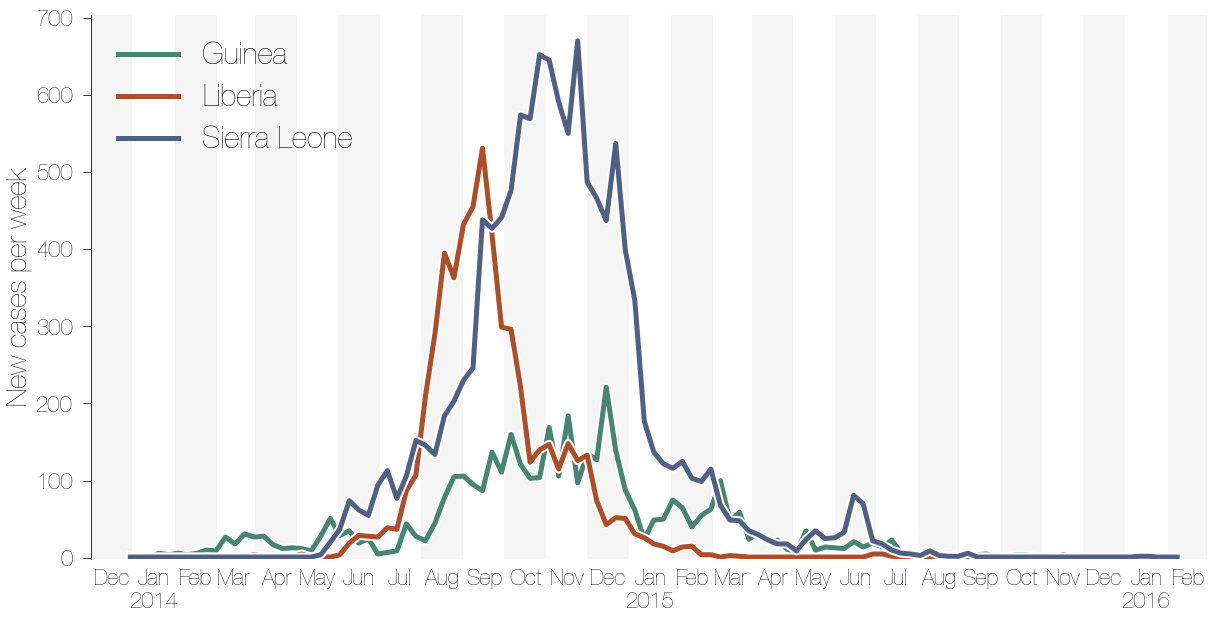

In [2]:
fig,ax = plt.subplots(figsize=(20, 10),facecolor='w') 

## choose whether to log-normalize or not
# logNorm=True
logNorm=False

## plot weekly case numbers
for country in cases_byCountry.keys():
    xkeys=sorted(cases_byCountry[country].keys(),key=lambda x:decimalDate(x))
    xs=[decimalDate(x) for x in xkeys]
    ys=[cases_byCountry[country][x]+1 for x in xkeys]
    ax.plot(xs,ys,color=colours[country](0.6),lw=5,label=translate[country],zorder=int(sum(ys)))
    ax.plot(xs,ys,color='w',lw=9,zorder=int(sum(ys))-1)

total=0
for country in cases_byCountry.keys():
    xkeys=sorted(cases_byCountry[country].keys(),key=lambda x:decimalDate(x))
    ys=[cases_byCountry[country][x] for x in xkeys]
    print 'total %s cases: %d'%(country,sum(ys))
    total+=sum(ys)
print 'total cases in West Africa: %d'%(total)

ax.legend(loc=2,frameon=False,fontsize=30)
    
ax.set_ylabel('New cases per week',size=28)
ax.set_xticks([decimalDate(x)+1/24.0 for x in timeline])
ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in timeline])
    
ax.set_xlim(decimalDate('2013-12-01'),decimalDate('2016-03-01'))

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.tick_params(axis='x',size=0,pad=10)
ax.tick_params(axis='y',which='major',size=8,direction='out',pad=10)
ax.tick_params(axis='y',which='minor',size=5,direction='out',pad=10)

[ax.axvspan(decimalDate(timeline[x]),decimalDate(timeline[x])+1/12.,facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(timeline),2)]

if logNorm==True:
    ax.set_ylim(bottom=1)
    ax.set_yscale('log')
    
elif logNorm==False:
    ax.set_ylim(bottom=-1)

# plt.savefig(local_output+'EBOV_cases.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_cases.pdf',dpi=300,bbox_inches='tight')
plt.show()

SLE 370
SLE WesternArea first suspected/confirmed case: 2014-06-09
SLE WesternUrban first suspected/confirmed case: 2014-06-09
SLE PortLoko first suspected/confirmed case: 2014-06-02
SLE WesternRural first suspected/confirmed case: 2014-06-23
SLE Bombali first suspected/confirmed case: 2014-06-09
SLE Kailahun first suspected/confirmed case: 2014-05-19
SLE Tonkolili first suspected/confirmed case: 2014-08-04
SLE Kono first suspected/confirmed case: 2014-06-30
SLE Kenema first suspected/confirmed case: 2014-06-02
SLE Bo first suspected/confirmed case: 2014-06-16
SLE Kambia first suspected/confirmed case: 2014-09-08
SLE Moyamba first suspected/confirmed case: 2014-06-09
SLE Koinadugu first suspected/confirmed case: 2014-08-04
SLE Pujehun first suspected/confirmed case: 2014-07-28
SLE Bonthe first suspected/confirmed case: 2014-07-14


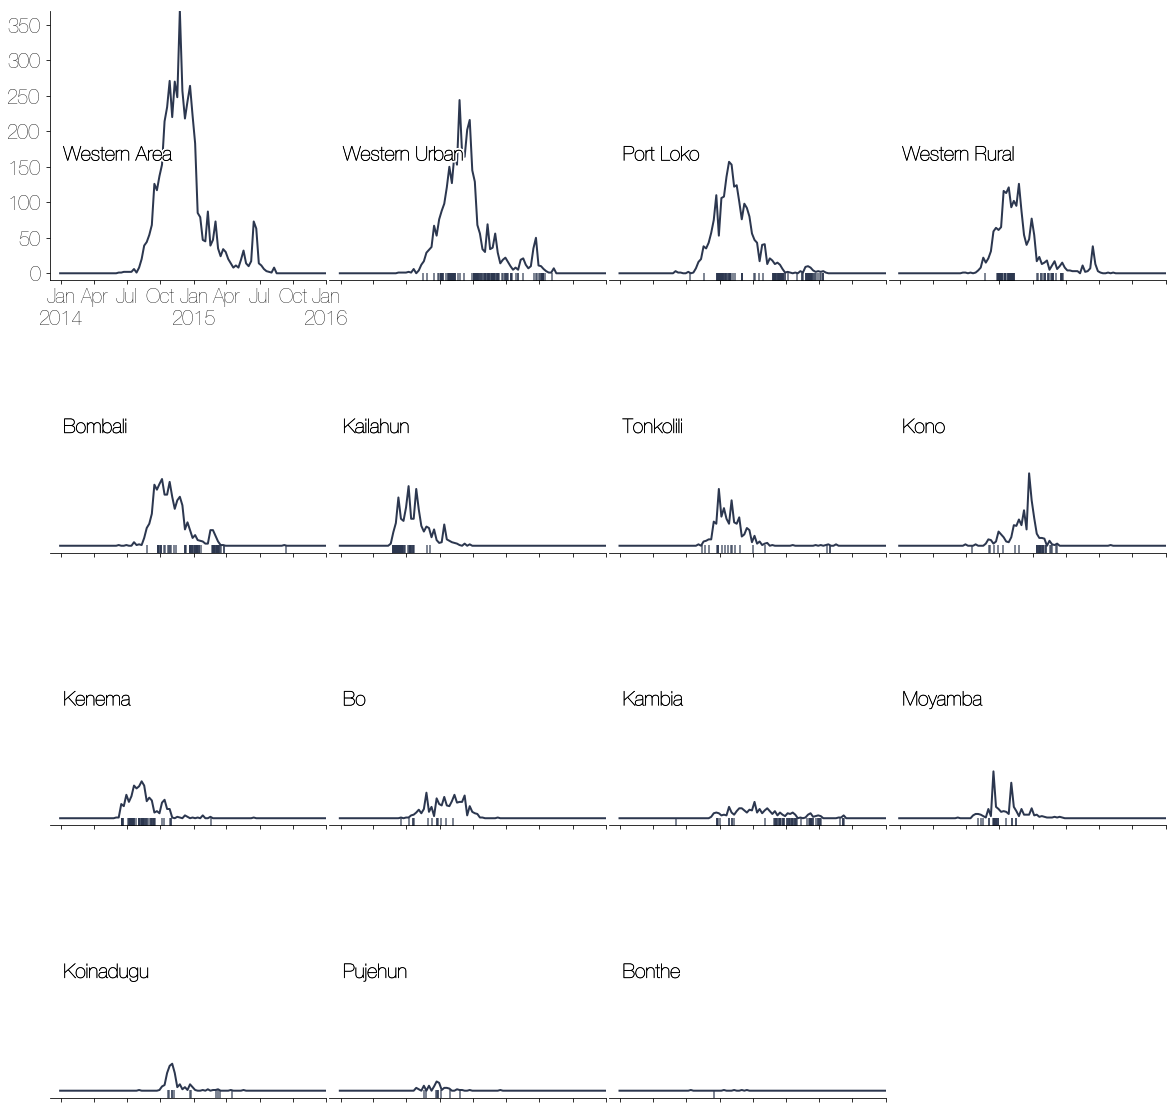

LBR 290
LBR Montserrado first suspected/confirmed case: 2014-05-05
LBR Margibi first suspected/confirmed case: 2014-03-24
LBR Lofa first suspected/confirmed case: 2014-03-17
LBR Nimba first suspected/confirmed case: 2014-05-05
LBR Bomi first suspected/confirmed case: 2014-06-16
LBR Bong first suspected/confirmed case: 2014-06-30
LBR GrandCapeMount first suspected/confirmed case: 2014-07-28
LBR GrandBassa first suspected/confirmed case: 2014-07-07
LBR RiverCess first suspected/confirmed case: 2014-07-07
LBR Sinoe first suspected/confirmed case: 2014-08-18
LBR Gbarpolu first suspected/confirmed case: 2014-08-04
LBR GrandKru first suspected/confirmed case: 2014-09-01
LBR RiverGee first suspected/confirmed case: 2014-08-04
LBR Maryland first suspected/confirmed case: 2014-08-11
LBR GrandGedeh first suspected/confirmed case: 2014-09-15


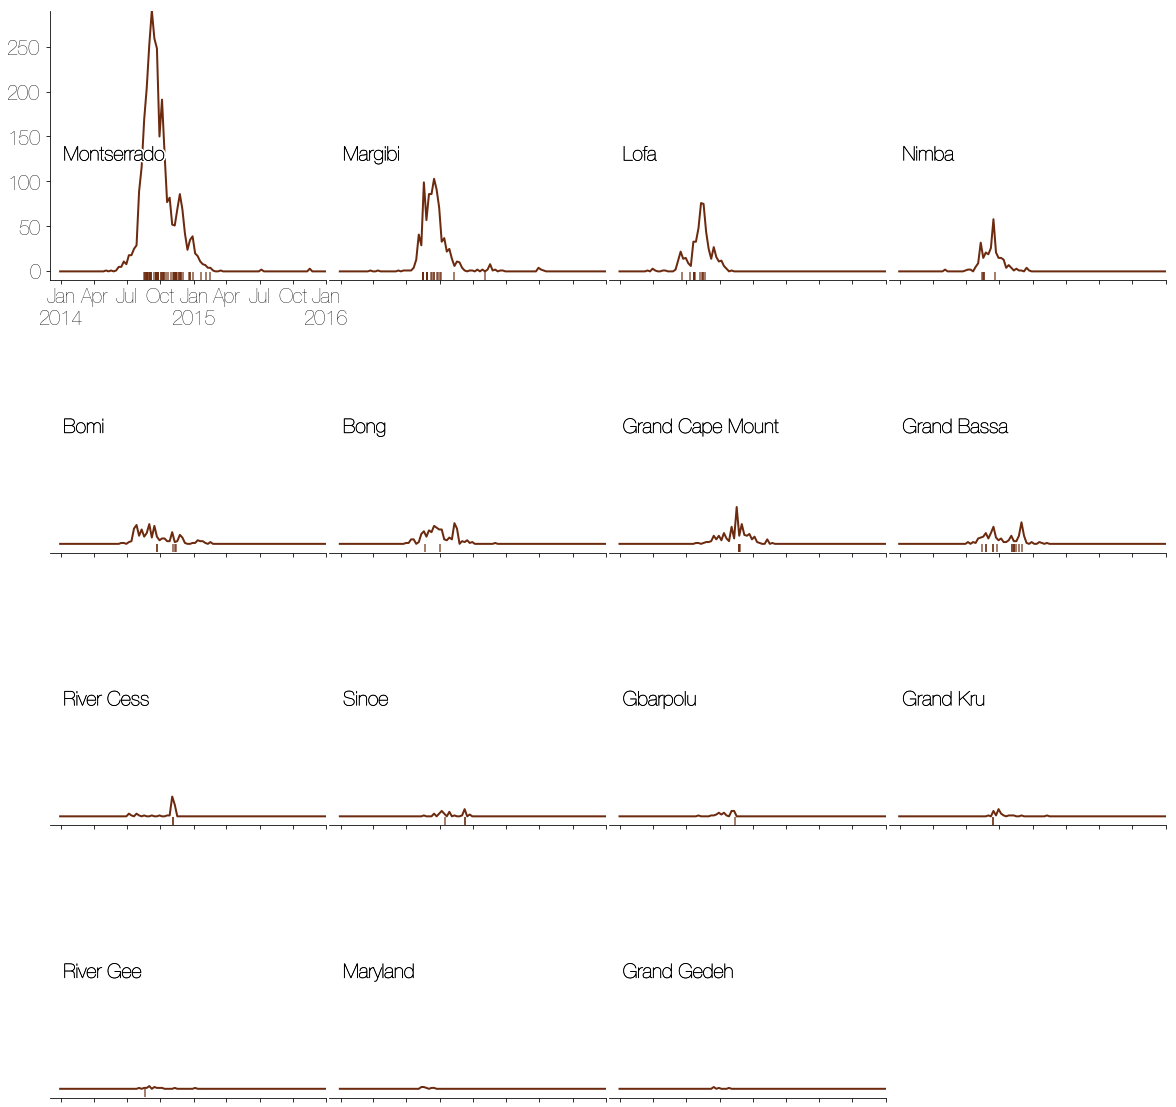

GIN 90
GIN Macenta first suspected/confirmed case: 2014-02-10
GIN Conakry first suspected/confirmed case: 2014-03-03
GIN Forecariah first suspected/confirmed case: 2014-08-25
GIN Gueckedou first suspected/confirmed case: 2013-12-30
GIN Nzerekore first suspected/confirmed case: 2014-07-28
GIN Coyah first suspected/confirmed case: 2014-07-21
GIN Kerouane first suspected/confirmed case: 2014-08-18
GIN Dubreka first suspected/confirmed case: 2014-08-11
GIN Kissidougou first suspected/confirmed case: 2014-03-03
GIN Kindia first suspected/confirmed case: 2014-06-02
GIN Lola first suspected/confirmed case: 2014-09-15
GIN Faranah first suspected/confirmed case: 2014-10-13
GIN Beyla first suspected/confirmed case: 2014-08-25
GIN Boffa first suspected/confirmed case: 2014-05-19
GIN Telimele first suspected/confirmed case: 2014-04-28
GIN Siguiri first suspected/confirmed case: 2014-03-31
GIN Kankan first suspected/confirmed case: 2014-09-08
GIN Boke first suspected/confirmed case: 2014-10-06
GIN 

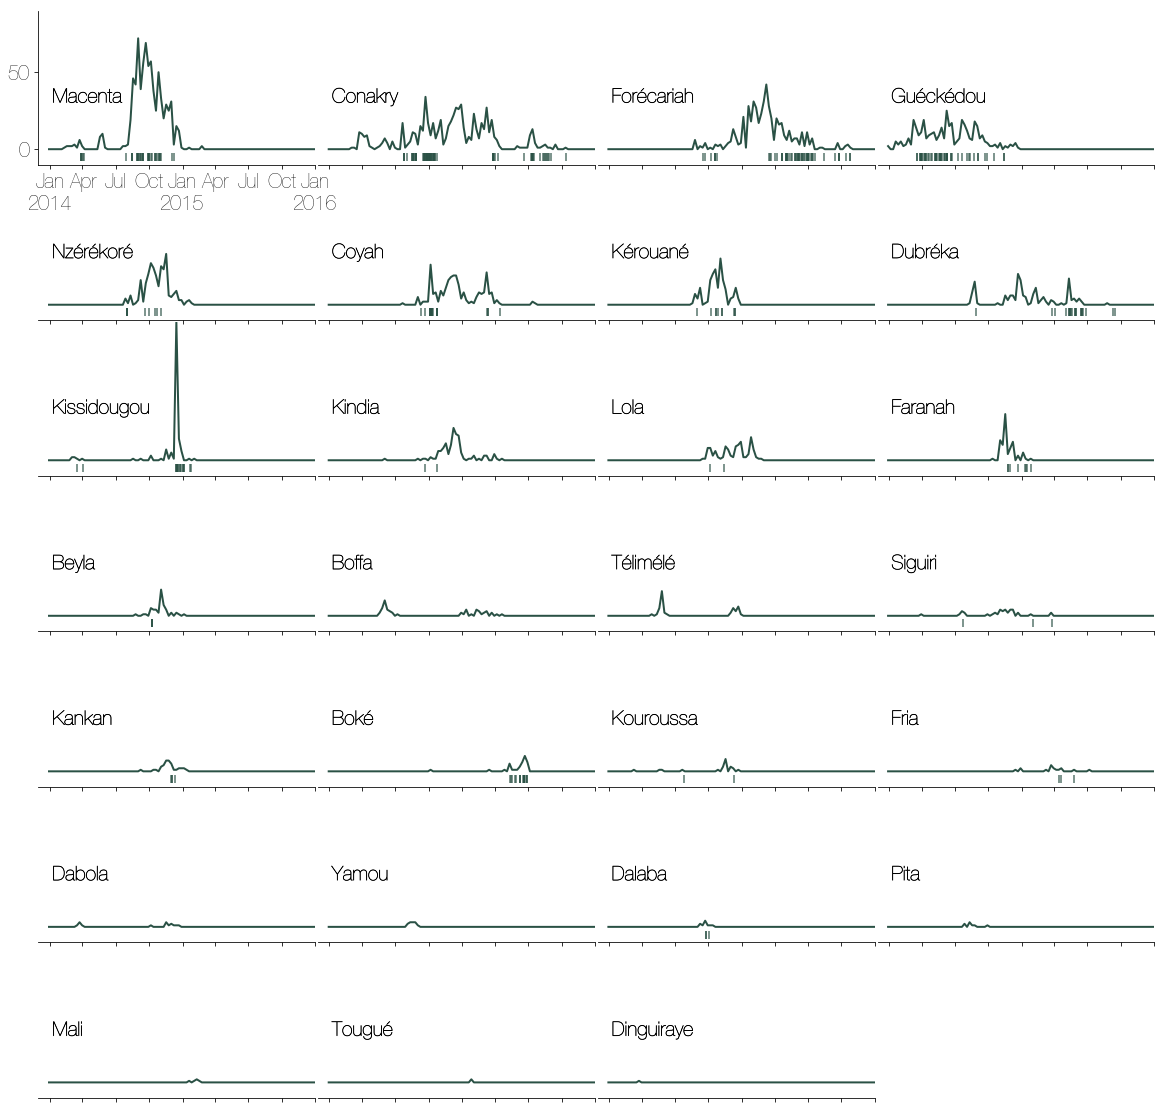

In [3]:
## this is for setting x ticks at some monthly interval
every=3
mons=['2013-%02d-01'%(x) for x in range(11,13,every)]
mons+=['2014-%02d-01'%(x) for x in range(1,13,every)]
mons+=['2015-%02d-01'%(x) for x in range(1,13,every)]
mons+=['2016-%02d-01'%(x) for x in range(1,3,every)]

effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='black')] ## black text, white outline

## iterate through countries 
for country in required_countries:

    ## collect all locations, sort by country
    locs=sorted(cases_byLocation.keys(),key=lambda x:location_to_country[x])
    
    ## then ignore locations without cases or from other countries
    ## sort it by total cases
    locs=sorted([x for x in locs if sum(cases_byLocation[x].values())>0 and location_to_country[x]==country],key=lambda a:-sum(cases_byLocation[a].values()))
    
    ## begin plot
    fig = plt.figure(figsize=(20, 20),facecolor='w') 
    
    ## define number of rows
    nrows=4

    ## plots is a grid
    gs = gridspec.GridSpec((len(locs)/nrows)+1, nrows) 

    ## define the y limit of each plot as the peak of the epidemic within the country
    extent=max([max(cases_byLocation[x].values()) for x in cases_byLocation.keys() if location_to_country[x]==country])
    print country,extent
    
    
    ## iterate through the plotting grid
    for i,g in enumerate(gs):
        ax=plt.subplot(g,zorder=len(locs)-i)
        
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(50))
        if i<len(locs):
            loc=locs[i]

            country=location_to_country[loc]
    
#             if country in ['SLE','LBR','GIN']:
    
            xs=sorted([x for x in cases_byLocation[loc].keys()],key = lambda c:decimalDate(c))
            ys=[cases_byLocation[loc][x] for x in xs]
            c=colours[country](0.9)
            
            print country,loc,'first suspected/confirmed case: %s'%([x for x,y in zip(xs,ys) if y>0][0])

            ax.plot([decimalDate(x) for x in xs],ys,color=c,lw=2)
            ax.tick_params(size=0,labelsize=0)

            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')

            if seq_byLocation.has_key(loc)>0:
                sequence_dates=[decimalDate(y[-1]) for x in seq_byLocation[loc].values() for y in x if len(x)>0]
                ax.scatter(sequence_dates,[-5 for x in sequence_dates],80,lw=2,color=c,marker='|',alpha=0.6)

            ax.text(0.05,0.5,'%s'%(map_to_actual[loc]),va='top',ha='left',transform=ax.transAxes,size=20,path_effects=effects)

            ax.xaxis.tick_bottom()
            ax.yaxis.tick_left()
            ## set x ticks according to monthly intervals
            ax.set_xticks([decimalDate(x) for x in mons])
            
            ## if currently at the very first plot - add x tick labels and make y axis ticks visible
            if i==0:
                ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%b\n%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in mons])
                ax.tick_params(axis='x',size=4,labelsize=20,direction='out',zorder=100)
                ax.tick_params(axis='y',size=4,labelsize=20,direction='out',pad=5)
            else:
                ax.spines['left'].set_color('none')
                ax.tick_params(axis='x',size=4,direction='out')
                ax.tick_params(axis='y',size=0,direction='out')
                ax.set_xticklabels([])
                ax.set_yticklabels([])

        else:
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.spines['left'].set_color('none')
            ax.spines['bottom'].set_color('none')
            ax.tick_params(size=0)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        ax.set_ylim(-10,extent)
        
        ax.set_xlim(decimalDate('2013-12-01'),decimalDate('2016-01-01'))
        ax.autoscale(enable=False) 
    
    ## make grid tighter
    gs.update(hspace=0.01,wspace=0.01)
#     plt.savefig(local_output+'EBOV_%s_sampling.png'%(country),dpi=300,bbox_inches='tight')
#     plt.savefig(local_output+'EBOV_%s_sampling.pdf'%(country),dpi=300,bbox_inches='tight')
    plt.show()

\begin{longtable}{ | p{.1\textwidth} | p{.25\textwidth} | p{.15\textwidth} | p{.15\textwidth} | p{.2\textwidth} | }
country & location & sequences & cases & \%% sequences/case \\ 
\hline
GIN & Macenta & 40 & 784 & 5.10 \\
GIN & Conakry & 73 & 629 & 11.61 \\
GIN & Forecariah & 60 & 502 & 11.95 \\
GIN & Gueckedou & 58 & 390 & 14.87 \\
GIN & Nzerekore & 9 & 269 & 3.35 \\
GIN & Coyah & 26 & 257 & 10.12 \\
GIN & Kerouane & 10 & 176 & 5.68 \\
GIN & Dubreka & 22 & 167 & 13.17 \\
GIN & Kissidougou & 18 & 138 & 13.04 \\
GIN & Kindia & 2 & 131 & 1.53 \\
GIN & Lola & 2 & 118 & 1.69 \\
GIN & Faranah & 8 & 88 & 9.09 \\
GIN & Beyla & 4 & 52 & 7.69 \\
GIN & Boffa & 0 & 52 & 0.00 \\
GIN & Telimele & 0 & 43 & 0.00 \\
GIN & Siguiri & 3 & 38 & 7.89 \\
GIN & Kankan & 4 & 38 & 10.53 \\
GIN & Boke & 18 & 36 & 50.00 \\
GIN & Kouroussa & 2 & 22 & 9.09 \\
GIN & Fria & 3 & 16 & 18.75 \\
GIN & Dabola & 0 & 15 & 0.00 \\
GIN & Yamou & 0 & 12 & 0.00 \\
GIN & Dalaba & 3 & 10 & 30.00 \\
GIN & Pita & 0 & 8 & 0.00 \\
G

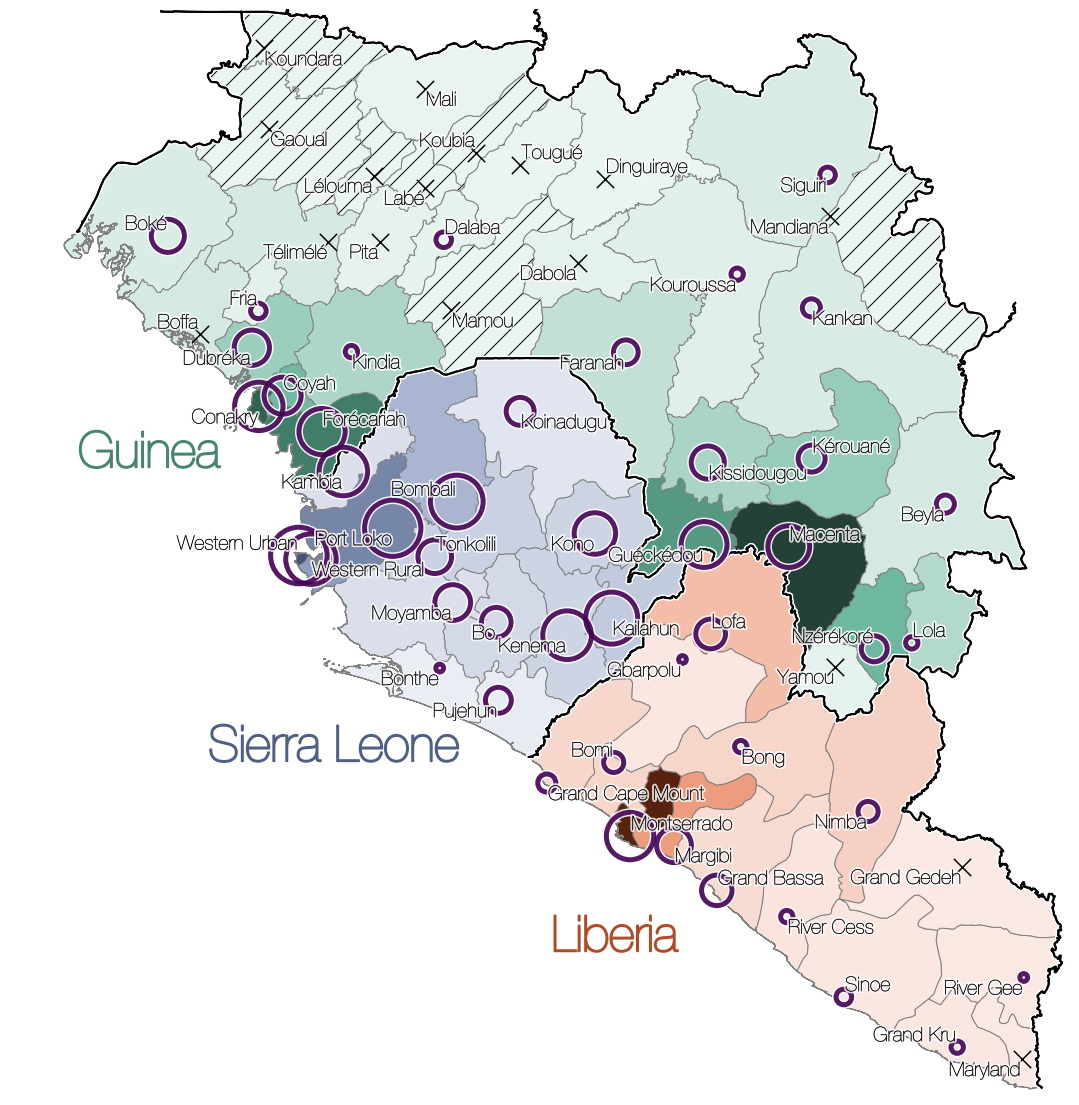

In [4]:
## colour map for coverage plots
# coverage_colours=mpl.cm.get_cmap('viridis')
coverage_colours=mpl.cm.viridis_r
coverage_alpha=0.9

## start figure
fig,ax = plt.subplots(figsize=(20,20),facecolor='w')

## find sequence coverage maximum or define it
# seq_coverage=[[q[5] for q in sequences].count(loc.split('_')[1])/float(totalCaseCounts[loc]) for loc in locations if totalCaseCounts[loc]>0]
seq_coverage=[0.5,0.5]

## cutoff for displaying >X%
seq_coverage=0.2

print '\\begin{longtable}{ | p{.1\\textwidth} | p{.25\\textwidth} | p{.15\\textwidth} | p{.15\\textwidth} | p{.2\\textwidth} | }'
print 'country & location & sequences & cases & \\%% sequences/case \\\\ '
# print maxByCountry

maxByCountry={country:0.001 for country in required_countries}
for location in cases_byLocation.keys():
    country=location_to_country[location]
    if country in required_countries:
        cases_in_location=sum(cases_byLocation[location].values())
        if maxByCountry[country]<=cases_in_location:
            maxByCountry[country]=cases_in_location

storeCountry=''
for i,loc in enumerate(sorted(cases_byLocation.keys(),key=lambda x:(location_to_country[x],-sum(cases_byLocation[x].values())))):
    country=location_to_country[loc]
    
    if country in required_countries and loc!='WesternArea':
        ## identify colour map
        countryColour=colours[country]

        ## find number of cases in the location
        cases_in_location=sum(cases_byLocation[loc].values())

        ## express cases as fraction of maximum cases seen in country
        c=countryColour(cases_in_location/float(maxByCountry[country]))

        ## add hatching for locations without EVD cases
        h=''
        if cases_in_location==0:
            h='/'

        ## mpl doesn't plot polygons unless explicitly told to plot something
        ax.plot()

        ## plot population centres
        lon,lat=popCentres[loc]

        if storeCountry!=country:
            print '\\hline'
        ## count how many times the location name turns up amongst sequences
        circleSize=[q[4] for q in sequences].count(loc)
        if cases_in_location==0:
            print '%s & %s & 0 & 0 & NA \\\\'%(country,loc)
        else:
            print '%s & %s & %d & %d & %.2f \\\\'%(country,loc,circleSize,cases_in_location,circleSize/float(cases_in_location)*100)


        if circleSize==0:
            ## if there are no sequences - plot X
            ax.scatter(lon,lat,300,marker='x',color='k',zorder=99)
        else:
            ## plot circle with radius proportional to log N sequences
            #coverage=(circleSize/float(cases_in_location))/float(seq_coverage)
            coverage=1.0
            if coverage>=1.0:
                coverage=1.0
            circle_colour=coverage_colours(coverage)
            ax.add_collection(PatchCollection([patches.Circle((lon,lat),radius=np.log10(circleSize+1)*0.1)],facecolor='none',
                                              alpha=coverage_alpha,edgecolor=circle_colour,lw=5,zorder=100))
            ax.add_collection(PatchCollection([patches.Circle((lon,lat),radius=np.log10(circleSize+1)*0.1)],facecolor='none',
                                              alpha=coverage_alpha,edgecolor='w',lw=8,zorder=99))

        ## plot location polygons
        ax.add_collection(PatchCollection(polygons[loc],facecolor=c,edgecolor='grey',lw=1,hatch=h,alpha=1.0))

        ## define available text alignments and corrections for text positions
        vas=['bottom','top']
        has=['left','right']
        corrections=[0.01,-0.01]

        ## set default text alignment (right, top)
        h=1
        v=1
        ## check if custom text positions are available
        if textCorrection.has_key(loc):
            h,v=textCorrection[loc]
        
        effect=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground='black')]
        ## plot location names at population centres, with corrections so as not to obscure it
        ax.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=20,va=vas[v],ha=has[h],alpha=0.8,path_effects=effect,zorder=101)
#         ax.text(lon+corrections[h],lat+corrections[v]*1.5,r'%s'%map_to_actual[loc],size=20,va=vas[v],ha=has[h],alpha=0.8,zorder=101)

        storeCountry=country
print '\\hline'
print '\\end{longtable}'
    
for local_border in global_border:
    ax.plot(column(local_border,0),column(local_border,1),color='k',lw=2,zorder=98)
    ax.plot(column(local_border,0),column(local_border,1),color='w',lw=5,zorder=97)

translate={'SLE':'Sierra Leone','LBR':'Liberia','GIN':'Guinea',
           'MLI':'Mali','SEN':'Senegal','GNB':'Guinea-Bissau','CIV':"Cote d'Ivoire"}

for label in ['GrandBassa','Pujehun','Conakry']:
    x,y=popCentres[label]
    country=location_to_country[label]
    countryName=translate[country]
    c=colours[country](0.6)
    effect=[path_effects.Stroke(linewidth=6, foreground='white'),path_effects.Stroke(linewidth=2, foreground=c)]
    
    ax.text(x-0.3,y-0.2,'%s'%(countryName),size=50,path_effects=effect,va='top',ha='right',zorder=100)
#     ax.text(x-0.3,y-0.2,'%s'%(countryName),size=50,va='top',ha='right',zorder=100)
    
# colorbarTextSize=30
# colorbarTickLabelSize=24
# colorbarWidth=0.02
# colorbarHeight=0.35
# gap=0.07
# height=0.07

# ax2 = fig.add_axes([0.1+gap, height, colorbarWidth, colorbarHeight])
# mpl.colorbar.ColorbarBase(ax2, cmap=colours['GIN'],norm=mpl.colors.LogNorm(vmin=1,vmax=maxByCountry['GIN']))
# ax2.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)
# ax2.yaxis.set_label_position('left') 
# ax2.set_ylabel('Guinea',color='k',size=colorbarTextSize)

# ax3 = fig.add_axes([0.1+gap*2, height, colorbarWidth, colorbarHeight])
# mpl.colorbar.ColorbarBase(ax3, cmap=colours['LBR'],norm=mpl.colors.LogNorm(vmin=1,vmax=maxByCountry['LBR']))
# ax3.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)
# ax3.yaxis.set_label_position('left') 
# ax3.set_ylabel('Liberia',color='k',size=colorbarTextSize)

# ax4 = fig.add_axes([0.1+gap*3, height, colorbarWidth, colorbarHeight])
# mpl.colorbar.ColorbarBase(ax4, cmap=colours['SLE'],norm=mpl.colors.LogNorm(vmin=1,vmax=maxByCountry['SLE']))
# ax4.tick_params(labelcolor='k',size=0,labelsize=colorbarTickLabelSize)
# ax4.yaxis.set_label_position('left') 
# ax4.set_ylabel('Sierra Leone',color='k',size=colorbarTextSize)

## define which circle sizes to display as legend
# exampleSizes=[1,2,5,10,15,20,30,50,100,150,200]
# for i,j in enumerate(exampleSizes):
#     x=-12.80+np.log10(j+1)*0.1+sum(np.log10([q+5 for q in exampleSizes[:i]]))*0.22
#     y=4.7
    
#     ## add circle with specified radius
# #     circle_colour=coverage_colours((i)/float(len(exampleSizes)-1))
#     circle_colour=coverage_colours(1.0)
#     ax.add_collection(PatchCollection([patches.Circle((x,y),radius=np.log10(j+1)*0.1)],facecolor='none',edgecolor=circle_colour,lw=5,zorder=99,alpha=coverage_alpha))
    
#     ax.text(x,y+np.log10(j+1)*0.11,j,size=24,ha='center',va='bottom',zorder=100)
# #     if (i+1)<len(exampleSizes):
# #         ax.text(x,y-np.log10(j+2)*0.13,'%.2f'%(((i)/float(len(exampleSizes)-1))*float(seq_coverage)),size=24,rotation=90,ha='center',va='top',zorder=100)
# #     else:
# #         ax.text(x,y-np.log10(j+2)*0.13,'>%.2f'%(((i)/float(len(exampleSizes)-1))*float(seq_coverage)),size=24,rotation=90,ha='center',va='top',zorder=100)
    
## plot labelling of example circles
# ax.text(-12.80,4.7+np.log10(exampleSizes[int(len(exampleSizes)/2)])*0.45,'number of sequences',va='top',ha='left',size=24)

## plot labelling of example circles
#ax.text(-12.75,4.7-np.log10(exampleSizes[int(len(exampleSizes)/2)])*0.45,'sequences/case',va='top',ha='left',size=24)

## make plot pretty
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(size=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(ylimits)
ax.set_xlim(xlimits)

# plt.savefig(local_output+'sampling.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'sampling.pdf',dpi=300,bbox_inches='tight')
plt.show()

cases: 26753
sequences: 1610
[2, 0, 0, 5, 3, 5, 3, 5, 9, 8, 26, 18, 31, 29, 28, 17, 11, 13, 15, 8, 31, 69, 67, 126, 108, 107, 125, 158, 122, 240, 285, 382, 486, 693, 712, 819, 861, 1179, 1097, 985, 1082, 1127, 1027, 1164, 1178, 1079, 1127, 1260, 1009, 882, 940, 989, 757, 607, 309, 280, 231, 242, 288, 194, 202, 252, 201, 121, 140, 87, 81, 56, 47, 38, 23, 76, 75, 51, 47, 60, 173, 145, 57, 45, 38, 13, 7, 5, 19, 5, 3, 2, 5, 3, 4, 0, 0, 3, 3, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
1610.0
Calculating expected sequences by redistributing all available sequences according to case numbers over the entire epidemic.


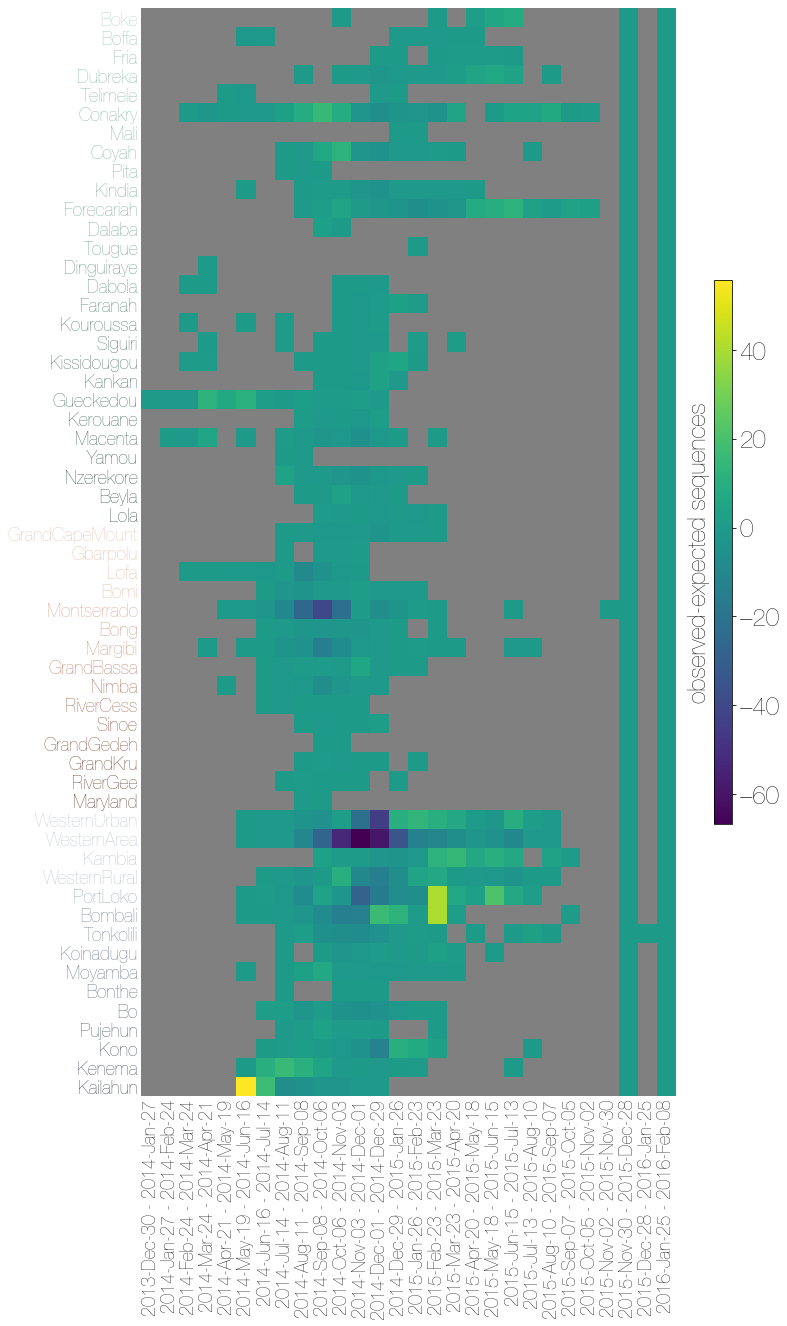

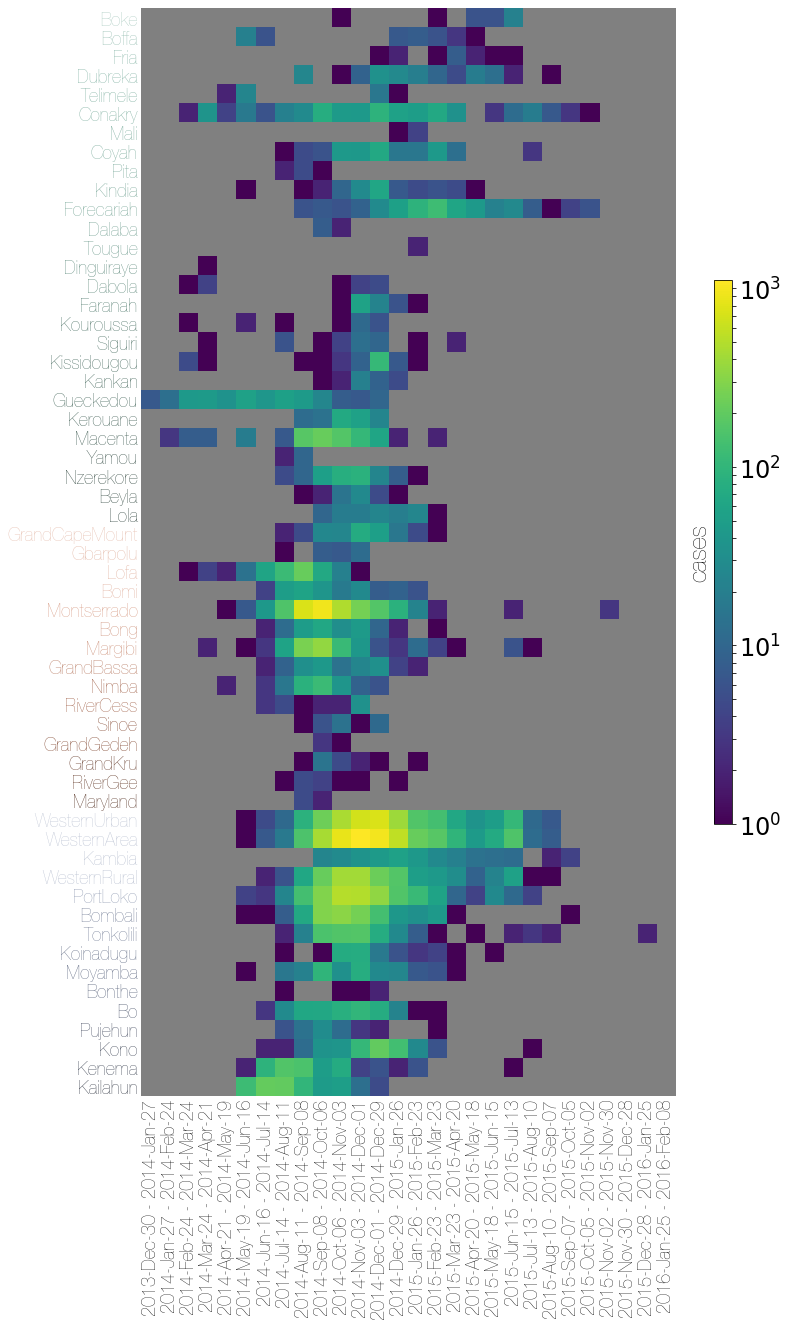

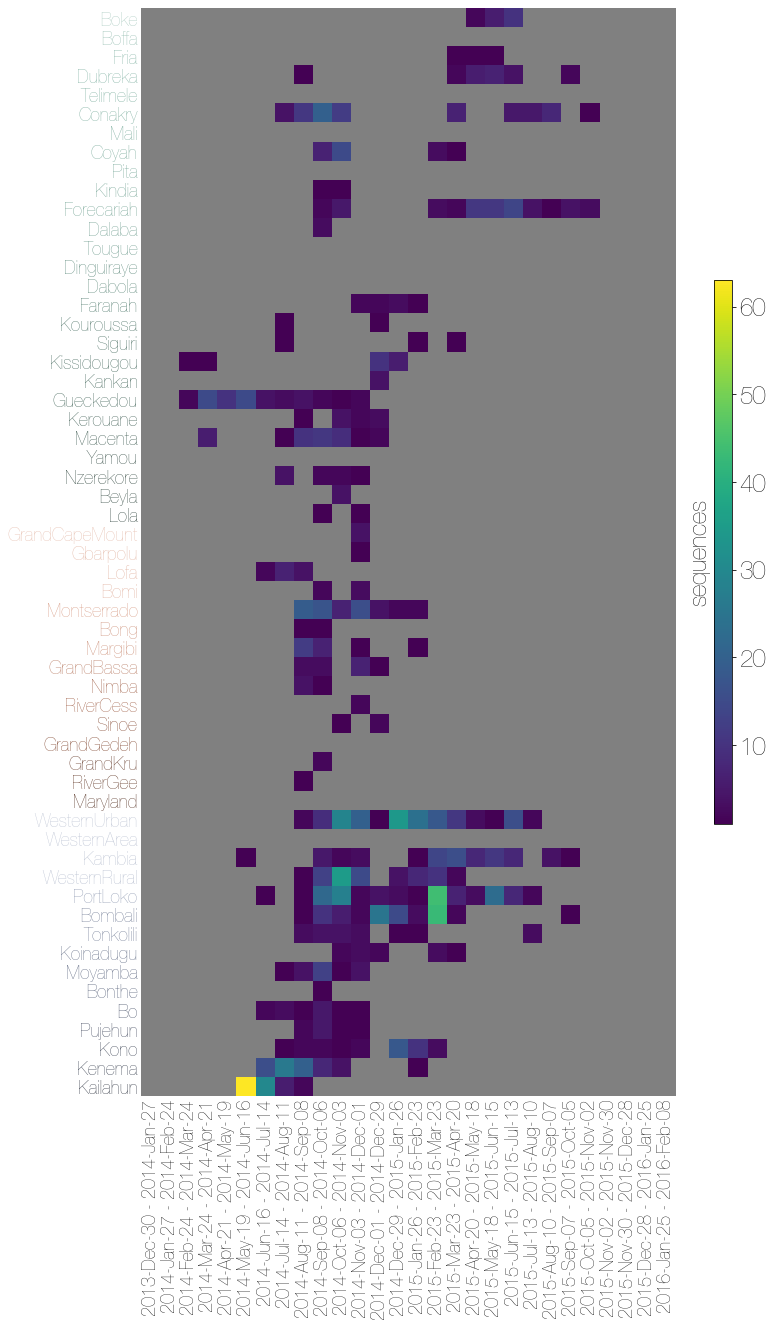

In [5]:
## choose how many epi weeks to lump together
partitioning=4

## sort locations by country and normalized coordinate
sorted_locations=sorted(cases_byLocation.keys(),key=lambda x:(location_to_country[x],normalized_coords[x]))
## only keep those with reported cases
sorted_locations=[x for x in sorted_locations if sum(cases_byLocation[x].values())>0]

## find total number of cases each location had during the entire epidemic
total_cases=sum([sum([cases_byLocation[q][y] for y in dates]) for q in sorted_locations])
total_seqs=len(sequences)

print 'cases: %d\nsequences: %d'%(total_cases,total_seqs)


print [sum([cases_byLocation[q][y] for q in sorted_locations]) for y in dates]

xlabels=[]

dateRange=range(0,len(dates),partitioning)

matrix=np.zeros((len(sorted_locations),len(dateRange)))
matrix.fill(np.nan)

case_matrix=np.zeros((len(sorted_locations),len(dateRange)))
case_matrix.fill(np.nan)

seqs_matrix=np.zeros((len(sorted_locations),len(dateRange)))
seqs_matrix.fill(np.nan)


seen=[]

## normalize observed-expected counts by assuming a fixed sequencing capacity within each time bin
# assumeSequencingCapacity=True
assumeSequencingCapacity=False

## normalize observed-expected counts by accounting for the number of cases within each time bin
# assumeCaseNumbers=True
assumeCaseNumbers=False


accumulateExpected=0

## iterate through timeslices
for z,j in enumerate(range(0,len(dates),partitioning)):
    if j+partitioning>=len(dates):
        start=dates[j]
        end=dates[-1]
    else:
        start=dates[j]
        end=dates[j+partitioning]

    ## setup x tick labels
    xlabels.append('%s - %s'%(convertDate(start,'%Y-%m-%d','%Y-%b-%d'),convertDate(end,'%Y-%m-%d','%Y-%b-%d')))

    ## determines which epi weeks are included in a slice
    epiweeks=dates[j:j+partitioning]
    
    ## find cases the location had across lumped dates
    cases=[sum([cases_byLocation[q][y] for y in epiweeks]) for q in sorted_locations]
    for i,x in enumerate(cases):
        if x==0:
            case_matrix[i][z]=np.nan
        else:
            case_matrix[i][z]=x

    seqs=[sum([len(seq_byLocation[q][y]) for y in epiweeks]) for q in sorted_locations]
    for i,x in enumerate(seqs):
        if x==0:
            seqs_matrix[i][z]=np.nan
        else:
            seqs_matrix[i][z]=x
        
    ## total cases across locations at time slice
    cases_in_locations={loc:sum([cases_byLocation[loc][w] for w in epiweeks]) for loc in sorted_locations}
    
    ## cases in slice is the sum across a column
    cases_in_slice=sum(cases_in_locations.values())
    
    if cases_in_slice==0.0:
        cases_in_slice=np.nan

    ## fraction of total cases in timeslice at location - only used when assuming case numbers
    case_fraction={loc:cases_in_locations[loc]/float(cases_in_slice) for loc in sorted_locations}
    
    ## fraction of total cases across entire epidemic in location
    # i.e. normalizes the number of cases a location has at a time point by the total number of cases the location had across the entire epidemic
    total_case_fraction={loc:cases_in_locations[loc]/float(total_cases) for loc in sorted_locations}
    
    ## observed numbers of sequences in each location
    sequences_in_locations={loc:sum([len(seq_byLocation[loc][w]) for w in epiweeks]) for loc in sorted_locations}
    observed_seqs=sequences_in_locations
    
    ## total number of sequences in timeslice
    sequences_in_slice=sum(sequences_in_locations.values())
    
    ## redistribute all cases and all sequences according to situation at the time
    if assumeSequencingCapacity==True and assumeCaseNumbers==True:
        ## number of sequences in slice * fraction of total cases a location has in timeslice
        # i.e. given the sequencing capacity at the time, how many sequences should we have?
        expected_seqs={loc:sequences_in_slice*case_fraction[loc] for loc in sorted_locations}
    
    ## redistribute sequences in a slice according to proportion of total cases at location
    if assumeSequencingCapacity==True and assumeCaseNumbers==False:
        ## if we had to redistribute available sequences at the time according to total number of cases
        expected_seqs={loc:sequences_in_slice*total_case_fraction[loc] for loc in sorted_locations}

    ## redistribute all cases and all sequences homogenously through the epidemic
    if assumeSequencingCapacity==False and assumeCaseNumbers==False:    
        ## total number of sequences * fraction of all cases a location had during the epidemic
        #i.e. assuming a homogenous epidemic, how many sequences should we have?
        expected_seqs={loc:total_seqs*total_case_fraction[loc] for loc in sorted_locations}

    ## redistribute all sequences according to proportion of total cases at location
    if assumeSequencingCapacity==False and assumeCaseNumbers==True:
        # if we had to redistribute all sequences according to case numbers at each time point
        expected_seqs={loc:total_seqs/float(len(dates2))/float(partitioning)*case_fraction[loc] for loc in sorted_locations}

        
    ## observed-expected sequences
    OE=[observed_seqs[loc]-expected_seqs[loc] for loc in sorted_locations]
    
    #print sum(expected_seqs),sum(observed_seqs),start,end
    if np.isnan(sum(expected_seqs.values()))==False:
        accumulateExpected+=sum(expected_seqs.values())
    
    for i,x in enumerate(OE):
        ## mask out matrix if location had no cases at the time
        if case_fraction[sorted_locations[i]]==0:
            matrix[i][z]=np.nan
        else:
            matrix[i][z]=x

print accumulateExpected
## output sampling matrices
# output=open('/Users/admin/Downloads/EBOV_expectedSequences.csv','w')
# print>>output,',%s'%(','.join(xlabels))
# print>>output,'\n'.join('%s,%s'%(x,','.join(map(str,matrix[i]))) for i,x in enumerate(sorted_locations))
# output.close()

# output=open('/Users/admin/Downloads/EBOV_observedSequences.csv','w')
# print>>output,',%s'%(','.join(xlabels))
# print>>output,'\n'.join('%s,%s'%(x,','.join(map(str,seqs_matrix[i]))) for i,x in enumerate(sorted_locations))
# output.close()

# output=open('/Users/admin/Downloads/EBOV_observedCases.csv','w')
# print>>output,',%s'%(','.join(xlabels))
# print>>output,'\n'.join('%s,%s'%(x,','.join(map(str,case_matrix[i]))) for i,x in enumerate(sorted_locations))
# output.close()

## start figure
fig,ax = plt.subplots(figsize=(len(matrix[0])/2,20),facecolor='w')

## mask out NaNs
masked_array = np.ma.array(np.array(matrix),mask=np.isnan(matrix))

## redistribute all cases and all sequences according to situation at the time
if assumeSequencingCapacity==True and assumeCaseNumbers==True:
    print 'Calculating expected sequences by redistributing sequences available within a time window according to case numbers within a time window.'

if assumeSequencingCapacity==True and assumeCaseNumbers==False:
    print 'Calculating expected sequences by redistributing sequences available within a time window according to case numbers over the entire epidemic.'

if assumeSequencingCapacity==False and assumeCaseNumbers==True:
    print 'Calculating expected sequences by redistributing all available sequences according to case numbers within a time window.'

if assumeSequencingCapacity==False and assumeCaseNumbers==False:
    print 'Calculating expected sequences by redistributing all available sequences according to case numbers over the entire epidemic.'

    
## set ticks and tick labels
ax.set_xticks(np.arange(0.0,len(xlabels)+0.0))
ax.set_xticklabels(xlabels,rotation=90)
ax.set_yticks(np.arange(0.0,len(sorted_locations)+0.0))
ax.set_yticklabels([x for x in sorted_locations])

## set colourmap
cmap=mpl.cm.get_cmap('viridis')
cmap.set_bad('grey')

## plot Observed-Expected sequences
heatmap = ax.imshow(masked_array,interpolation='nearest',cmap=cmap,alpha=1)

## add colourbar
cbar = plt.colorbar(heatmap,ax=ax,shrink=0.5,aspect=30)
cbar.ax.yaxis.set_label_position('left') 
cbar.ax.set_ylabel('observed-expected sequences',size=24)
cbar.ax.tick_params(labelsize=24)

## make plot pretty
ax.tick_params(size=0,labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

for tick in ax.yaxis.get_ticklabels():
    label=str(tick.get_text())
    location=label
    country=location_to_country[location]
    tick.set_text(location)
    tick.set_color(desaturate(colours[country](normalized_coords[location]),0.7))

ax.set_yticklabels(sorted_locations)

# plt.savefig(local_output+'EBOV_sampling_heatmap_combine%02d.png'%(partitioning),dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_sampling_heatmap_combine%02d.pdf'%(partitioning),dpi=300,bbox_inches='tight')


plt.show()

## start figure
fig,ax = plt.subplots(figsize=(len(matrix[0])/2,20),facecolor='w')

## mask out NaNs
masked_array = np.ma.array(np.array(case_matrix),mask=np.isnan(case_matrix))

## set up ticks and tick labels for the plot
ax.set_xticks(np.arange(0.0,len(xlabels)+0.0))
ax.set_xticklabels(xlabels,rotation=90)
ax.set_yticks(np.arange(0.0,len(sorted_locations)+0.0))
ax.set_yticklabels([x for x in sorted_locations])

## set colourmap
cmap=mpl.cm.get_cmap('viridis')
cmap.set_bad('grey')
## plot cases
heatmap = ax.imshow(masked_array,interpolation='nearest',cmap=cmap,alpha=1,norm=mpl.colors.LogNorm())

## add colourbar
cbar = plt.colorbar(heatmap,ax=ax,shrink=0.5,aspect=30)
cbar.ax.yaxis.set_label_position('left') 
cbar.ax.set_ylabel('cases',size=24)
cbar.ax.tick_params(labelsize=24)

## make plot pretty
ax.tick_params(size=0,labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

for tick in ax.yaxis.get_ticklabels():
    label=str(tick.get_text())
    location=label
    country=location_to_country[location]
    tick.set_text(location)
    tick.set_color(desaturate(colours[country](normalized_coords[location]),0.7))

ax.set_yticklabels(sorted_locations)

# plt.savefig(local_output+'EBOV_cases_heatmap_combine%02d.png'%(partitioning),dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_cases_heatmap_combine%02d.pdf'%(partitioning),dpi=300,bbox_inches='tight')

plt.show()


## start figure
fig,ax = plt.subplots(figsize=(len(matrix[0])/2,20),facecolor='w')

## mask out NaNs
masked_array = np.ma.array(np.array(seqs_matrix),mask=np.isnan(seqs_matrix))

## set up ticks and tick labels for the plot
ax.set_xticks(np.arange(0.0,len(xlabels)+0.0))
ax.set_xticklabels(xlabels,rotation=90)
ax.set_yticks(np.arange(0.0,len(sorted_locations)+0.0))
ax.set_yticklabels([x for x in sorted_locations])

## set colourmap
cmap=mpl.cm.get_cmap('viridis')
cmap.set_bad('grey')
## plot cases
heatmap = ax.imshow(masked_array,interpolation='nearest',cmap=cmap,alpha=1,norm=mpl.colors.Normalize())

## add colourbar
cbar = plt.colorbar(heatmap,ax=ax,shrink=0.5,aspect=30)
cbar.ax.yaxis.set_label_position('left') 
cbar.ax.set_ylabel('sequences',size=24)
cbar.ax.tick_params(labelsize=24)

## make plot pretty
ax.tick_params(size=0,labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

for tick in ax.yaxis.get_ticklabels():
    label=str(tick.get_text())
    location=label
    country=location_to_country[location]
    tick.set_text(location)
    tick.set_color(desaturate(colours[country](normalized_coords[location]),0.7))

ax.set_yticklabels(sorted_locations)
    
# plt.savefig(local_output+'EBOV_sequences_heatmap_combine%02d.png'%(partitioning),dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'EBOV_sequences_heatmap_combine%02d.pdf'%(partitioning),dpi=300,bbox_inches='tight')

plt.show()

Spearman correlation coefficient: 0.88
p-value: 0.0000


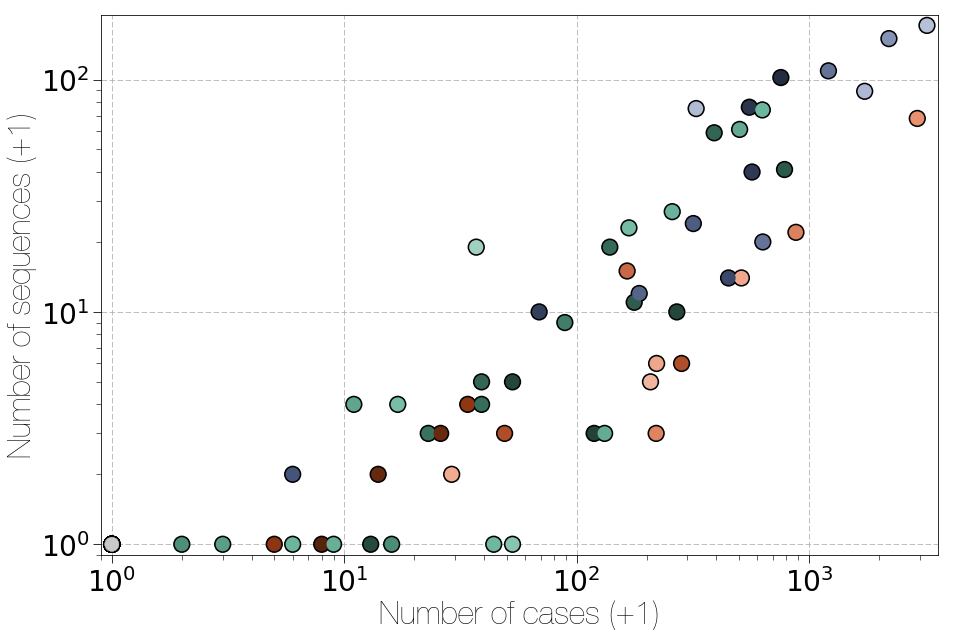

In [6]:
from scipy.stats import spearmanr

# start figure
fig,ax = plt.subplots(figsize=(15,15),facecolor='w')

c={x:sum(cases_byLocation[x].values())+1 for x in cases_byLocation}
s={x:sum([len(y) for y in seq_byLocation[x].values()])+1 for x in seq_byLocation}

vas=['bottom','top']
has=['left','right']
corrections=[0.01,-0.01]

for loc in cases_byLocation:
    country=location_to_country[loc]
    countryColour=colours[country]

    ## set default text alignment (right, top)
    h=1
    v=1
    ## check if custom text positions are available
    if textCorrection.has_key(loc):
        h,v=textCorrection[loc]
    
#     print loc,c[loc],s[loc]
    if s[loc]>0 and c[loc]>0:
        k=countryColour(normalized_coords[loc])
#         k=countryColour(0.5)
        ax.scatter(c[loc],s[loc],s=200,facecolor=k,edgecolor='none',zorder=100)
        ax.scatter(c[loc],s[loc],s=300,facecolor='k',edgecolor='none',zorder=99)
        effects=[path_effects.Stroke(linewidth=4, foreground='white'),path_effects.Stroke(linewidth=0.5, foreground=countryColour(normalized_coords[loc]))]
#         ax.text(c[loc],s[loc],'%s'%(map_to_actual[location]),size=14,va=vas[v],ha=has[h],path_effects=effects,alpha=1)
        #ax.text(c[loc],s[loc],'%s'%(map_to_actual[loc]),size=14,va='top',ha='right',path_effects=effects,alpha=1)
    
xs=[c[x] for x in cases_byLocation]
ys=[s[x] for x in cases_byLocation]

r,pval=spearmanr(xs,ys)

print 'Spearman correlation coefficient: %.2f\np-value: %.4f'%(r,pval)

ax.set_xlim(0.9,3600)
ax.set_ylim(0.9,190)

ax.set_yscale('log')
ax.set_xscale('log')

for label in ax.get_yticklabels() :
    label.set_fontproperties(typeface)

ax.tick_params(size=8,which='major',labelsize=28)
ax.tick_params(size=5,which='minor',labelsize=28)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Number of cases (+1)',size=32)
ax.set_ylabel('Number of sequences (+1)',size=32)
ax.grid(ls='--',which='major')

ax.set_aspect(1)

# plt.savefig(local_output+'samplingCorrelations.png',dpi=300,bbox_inches='tight')
# plt.savefig(local_output+'samplingCorrelations.pdf',dpi=300,bbox_inches='tight')

plt.show()